## How have online discussions and sentiment around the #MeToo movement on YouTube evolved over time?
idea: check on wikipedia pageview for #MeToo and where there was a lot of traffic. (maybe heatmap if there are too many time series?)
use this date to check for youtube videos in that time, see how people felt/reacted to the trend. 
check videos at the beginning of hype, the middle of hype and then the last 3 years, and how the opinions have changed (sentiment analysis tool, textblob?)

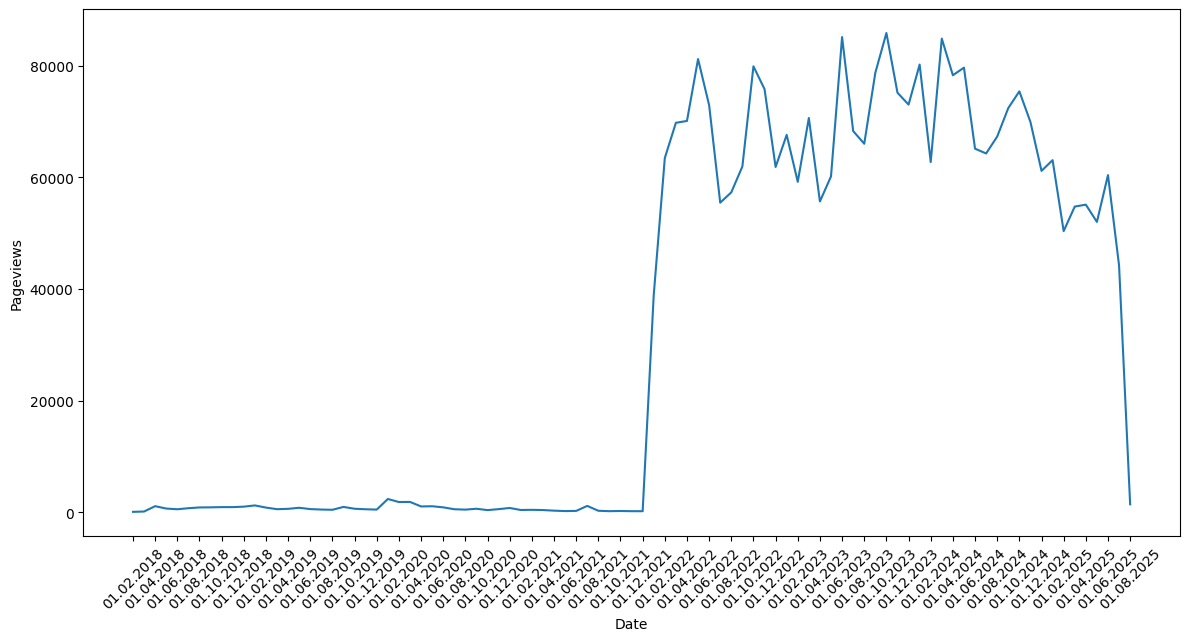

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import requests as rq

headers = {
    "User-Agent": "Wikimedia Analytics(Dianer)",}

view_url = """https://wikimedia.org/api/rest_v1/metrics/pageviews/\
per-article/en.wikipedia.org/all-access/all-agents/\
MeToo_movement/monthly/20160101/20250801"""
view_response = rq.get(view_url, headers=headers).json()

view_df = pd.DataFrame.from_records(view_response["items"])
view_df["timestamp"] = pd.to_datetime(view_df["timestamp"], format="%Y%m%d%H")
view_df["timestamp"]  = view_df["timestamp"].dt.strftime('%d.%m.%Y')
view_df = view_df.set_index("timestamp")
view_df = view_df.drop(columns=["project", "article", "granularity", "access", "agent"])

view_df.to_csv("wikipedia_meToo_data.csv", encoding="utf-8")

plt.figure(figsize=(12,6))
plt.plot(view_df.index, view_df['views'])
plt.xlabel("Date")
plt.ylabel("Pageviews")
plt.tight_layout()
plt.xticks(view_df.index[::2], rotation=45)
plt.show()

Hype-begin: 01.01.2022
Peak: 01.10.2023



In [ ]:
import pandas as pd
from googleapiclient.discovery import build
from collections import OrderedDict
api_key = ""
youtube = build("youtube", "v3", developerKey= api_key)

def flatten(xss):
    ''' function that flattens one list
       i: list in list
       o: list'''
    return [x for xs in xss for x in xs]

def search_video(before=None, after=None, filename="input.csv"):
    '''searches youtube videos with given parameters
       and saves them as a csv'''
    all_videos = []
    next_page_token = None
    max_pages = 1
    current_page = 0

    while current_page < max_pages:
        parameters = {
            "q": "#MeToo",
            "maxResults": 50,
            "part": "snippet",
            "order": "relevance",
            "type": "video",
             "videoCategoryId": "25" # Politics and news
        }
        if before is not None:
            parameters["publishedBefore"] = before
        if after is not None:
            parameters["publishedAfter"] = after
        if next_page_token:
            parameters["pageToken"] = next_page_token

        request = youtube.search().list(**parameters)
        response = request.execute()
        all_videos.extend(response["items"])

        next_page_token = response.get("nextPageToken")
        current_page += 1

    # List of video ids
    ids = []
    for item in all_videos:
        ids.append(item["id"]["videoId"])
    titles = []
    for item in all_videos:
        titles.append(item["snippet"]["title"])

    # getting comments for each video
    all_comments = []
    for videoid in ids:
        video_comments = []
        try:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=videoid,
                maxResults=100,
                textFormat="plainText",
                order="relevance"
            )
            response = request.execute()
            for c in response.get("items", []):
                video_comments.append(c["snippet"]["topLevelComment"]["snippet"]["textDisplay"])

        # Comments may be disabled
        except Exception as e:
            continue

        all_comments.append(video_comments)

    comments = flatten(all_comments)
    final_data = titles + comments
    df = pd.DataFrame(final_data, columns=["text"])
    df.to_csv(filename, index=False, encoding="utf-8")
    return final_data



In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def calculate_sentiment(data, filename="input.csv"):
    '''calculates the sentiment (positive, neutral, negative)
       of each title + comment. 
       i: comment, titles in a list
       o: dict. with total amount of pos/neu/neg comments'''
    analyzer = SentimentIntensityAnalyzer()
    counts = {"positive": 0, "neutral": 0, "negative": 0}

    for text in data:
        score = analyzer.polarity_scores(text)["compound"]
    
        if score >= 0.05:
            counts["positive"] += 1
        elif score <= -0.05:
            counts["negative"] += 1
        else:
            counts["neutral"] += 1

    df = pd.DataFrame([counts])
    df.to_csv(filename, index=False, encoding="utf-8")






In [ ]:
data1 = search_video("2021-06-01T00:00:00Z", "2018-01-01T00:00:00Z", filename="beforeHypeRawData.csv")
calculate_sentiment(data1, "sentimentBeforeHype.csv")
data2 = search_video("2021-12-01T00:00:00Z", "2022-07-01T00:00:00Z", filename="earlyHypeData.csv")
calculate_sentiment(data2, "sentimentEarlyHype.csv")
data3 = search_video("2023-01-01T00:00:00Z", "2022-01-01T00:00:00Z", filename="PeakHypeData.csv")
calculate_sentiment(data3, "sentimentPeakHype.csv")
data4 = search_video("2024-01-01T00:00:00Z", "2023-01-01T00:00:00Z", filename="sustainedHypeRawData.csv")
calculate_sentiment(data4, "sentimentSustainedHype.csv")
data5 = search_video(after= "2024-01-01T00:00:00Z", filename="declineHypeRawData.csv")
calculate_sentiment(data5, "sentimentDeclineHype.csv")